In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    return pd.read_sql_query(query, conn)

In [9]:
data = sql('''SELECT DISTINCT
	depositAddress.address depositAddress, count(*)
FROM 
	address depositAddress
	INNER JOIN
	Transfer t
	INNER JOIN
	address senderAddress
	INNER JOIN
	AddressMetadata senderMeta
	ON 
        senderAddress.address = t.`from` and 
        t.`to` = depositAddress.address and 
        senderAddress.address = senderMeta.address
WHERE 
	depositAddress.isDepositAddress = 1 and 
    depositAddress.isCappReceiver = 0 and 
	senderAddress.isCappSender = 0 and
	senderAddress.isCappReceiver = 0 and
	senderAddress.isCappOther = 0 and
	senderAddress.isCappStorage = 0 and
	senderAddress.isDepositAddress = 0 AND
	senderMeta.distinctOutDegree < 5
GROUP BY depositAddress.address
HAVING count(*) > 1
ORDER BY count(*) DESC''')

In [15]:
print(data.shape[0])
print(data['count(*)'].sum() - data.shape[0])

116285
311374


In [29]:
sql('''SELECT count(*), avg(amountInUSDCurrent) FROM Transfer WHERE amountInUSDCurrent < 10000000 and isChangeTransfer = 1''')

,count(*),avg(amountInUSDCurrent)
0,9487,6781.443381


In [30]:
sql('''SELECT count(*), avg(amountInUSDCurrent) FROM Transfer WHERE amountInUSDCurrent < 10000000 and isChangeTransfer = 0''')

,count(*),avg(amountInUSDCurrent)
0,55365106,1378.062469


In [33]:
sql('''SELECT count(*) FROM Transfer WHERE
    Transfer.emptiedAccount = 1 and
    EXISTS (
        SELECT * FROM AddressMetadata m
        WHERE m.canBePaperWallet = 'YES' and m.address = Transfer.`from`
    ) and Transfer.`to` in (SELECT address FROM AddressMetadata WHERE distinctInDegree > 30)''')

,count(*)
0,27090


In [5]:
data = sql('''SELECT DISTINCT
	senderAddress.address, count(distinct depositAddress.address) as numDepositAddresses, senderMeta.distinctOutDegree
FROM 
	address depositAddress
	INNER JOIN
	Transfer t
	INNER JOIN
	address senderAddress
	INNER JOIN
	AddressMetadata senderMeta
	ON 
        senderAddress.address = t.`from` and 
        t.`to` = depositAddress.address and 
        senderAddress.address = senderMeta.address
WHERE 
	depositAddress.isDepositAddress = 1 and 
    depositAddress.isCappReceiver = 0
GROUP BY senderAddress.address
HAVING numDepositAddresses > 1
ORDER BY numDepositAddresses DESC''')

,address,numDepositAddresses,distinctOutDegree
0,0x0000000000000000000000000000000000000000,219892,1646855
1,0x610ff0ca7c04b1f8e06e12aa5b85c6f9502b5b63,15037,47200
2,0x6a3eb79e1c4023f1610ff046c5dc30f9790d326f,14289,16946
3,0x2b5634c42055806a59e9107ed44d43c426e58258,14201,193774
4,0xd551234ae421e3bcba99a0da6d736074f22192ff,12885,113831
5,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,12614,112963
6,0x564286362092d8e7936f0549571a803b203aaced,12083,106257
7,0xd94c9ff168dc6aebf9b6cc86deff54f3fb0afc33,11236,30149
8,0xca5c301245f2781c2c4304426ab682d9744f7eb6,9578,30885
9,0xb638498bd551978fa4916a139e094db35c1bc55d,9523,23949


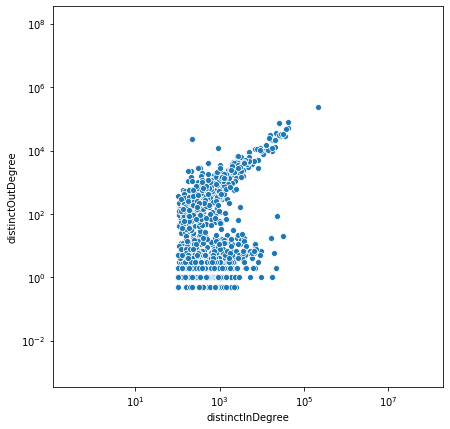

In [16]:
data = sql('''SELECT distinctInDegree, distinctOutDegree FROM address Natural JOIN addressMetadata where isCappReceiver = 1''')

data.loc[data['distinctInDegree'] == 0, ['distinctInDegree']] = 0.5
data.loc[data['distinctOutDegree'] == 0, 'distinctOutDegree'] = 0.5
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(data=data, ax=ax, x='distinctInDegree', y='distinctOutDegree')